# 1 - Configuring a Workforce Project Using the ArcGIS API for Python

This is first of a series of Jupyter Notebooks designed to demonstrate how the ArcGIS API for Python can be used to automate many aspects of Workforce for ArcGIS.

Workforce for ArcGIS is a mobile solution that uses the power of location-based decision making for better field workforce coordination and teamwork. Everything in Workforce is center around the Workforce Project. A project consists of many things including workers, dispatchers, assignments, and app integrations. A project is typically configured through the user interface as described [here](https://doc.arcgis.com/en/workforce/android-phone/help/create-your-first-project.htm). For many users, this experience is totally fine. However, for other users who have complex or recurring projects this can be quite time-consuming. In this guide we'll demonstrate how many of those configuration tasks can be automated by using the [ArcGIS API for Python](https://developers.arcgis.com/python/).

This guide uses the ArcGIS API for Python version 1.5.1 with Python 3.6+.

### Importing the Workforce Module

Let's get started! The ArcGIS API for Python provides a [module](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.apps.workforce.html) specifically for working with Workforce Projects. Let's first import that module.

In [1]:
from arcgis.apps import workforce

### Connecting to your organization

Now we'll connect to our organization as the owner of an existing workforce Project.

In [2]:
from arcgis.gis import GIS
gis = GIS("https://arcgis.com", "workforce_scripts")

Enter password: ········


### Searching for and using an existing project

Next, let's find a specific project in our organization that we'd like to configure.

<Item title:"Public Works Work Orders" type:Workforce Project owner:workforce_scripts>
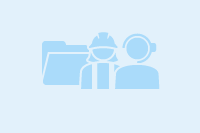

In [3]:
item = gis.content.search("type:'Workforce Project' 'Public Works Work Orders'")[0]
item

Let's create a [Project](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.apps.workforce.html#project) object from that item so we can leverage the workforce module to easily configure it.

In [4]:
project = workforce.Project(item)

### Adding assignment types

Now that we have a `Project` to work with, let's add a few assignment types. We'll use the [AssignmentTypeManager](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.apps.workforce.managers.html#assignmenttypemanager) object, which is a [property](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.apps.workforce.html#arcgis.apps.workforce.Project.assignment_types) of the `Project`, to accomplish this.

In [5]:
project.assignment_types.add(name="Fill in Pothole")
project.assignment_types.add(name="Sidewalk Repair")
project.assignment_types.add(name="Paint Crosswalk")
project.assignment_types.search()

[<AssignmentType 1>, <AssignmentType 2>, <AssignmentType 3>]

### Adding workers to the project

Now let's add some workers to the project. We are going to import workers from an existing group in our organization. Let's first find the group of workers.

<Group title:"Road Repair Crew" owner:workforce_scripts>
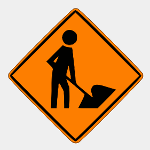

In [6]:
repair_crew_group = gis.groups.search("Road Repair Crew")[0]
repair_crew_group

For each member in the group, we'll add them as a worker to the project. We'll use the [WorkerManager](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.apps.workforce.managers.html#workermanager) class, which is available as a [property](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.apps.workforce.html#arcgis.apps.workforce.Project.workers) on the `Project`, to add the users one by one. If there were a lot of users, we could use the [batch_add](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.apps.workforce.html#project) method to add a list of [Workers](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.apps.workforce.html#worker) all at once.

In [7]:
for username in repair_crew_group.get_members()["users"]:
    user = gis.users.get(username)
    project.workers.add(user_id=username, name=user.fullName, status="not_working")

### Adding dispatchers to the project

Now let's add some dispatchers to the project from a CSV file. We'll use the [pandas](https://pandas.pydata.org/) library to help us out.

In [8]:
import pandas as pd
dataframe = pd.read_csv("data/dispatchers.csv")
dataframe

,name,contactNumber,userId
0,Mabel Ney,1234567890,mabel_nitro
1,Craig Gillgrass,987654321,cgillgrass_nitro


As shown above, we have 2 users to add. For every row in the csv file, let's add a new [dispatcher](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.apps.workforce.html#dispatcher) to the project. We'll use the [DispatcherManager](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.apps.workforce.managers.html#dispatchermanager) class, which is available as a [property](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.apps.workforce.html#arcgis.apps.workforce.Project.dispatchers) on the `Project`, to add the users one by one. If there were a lot of users, we could use the [batch_add](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.apps.workforce.managers.html#arcgis.apps.workforce.managers.DispatcherManager.batch_add) method to add a list of [Dispatchers](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.apps.workforce.html#dispatcher) all at once.

In [9]:
for row in dataframe.itertuples():
    project.dispatchers.add(
        name=row.name,
        contact_number=row.contactNumber,
        user_id=row.userId
    )

### Adding an app integration

As the final step of configuring the project, let's add the ability to open [Explorer for ArcGIS](https://doc.arcgis.com/en/explorer/) at the assignment location. We'll search the organization for the desired map.

In [10]:
from arcgis.mapping import WebMap
webmap = WebMap(gis.content.search("Portland Streets owner:workforce_scripts")[0])

Now, let's share this map with the `Project` group so that all dispatchers and workers can access it.

In [11]:
webmap.item.share(groups=[project.group])

{'notSharedWith': ['', '93b947caff5a4363b302ea84b9b7a745'],
 'itemId': 'db364a0b4c194f0c9c2d46b10c637922'}

Next, we'll create the [url scheme](https://github.com/Esri/explorer-integration) used to launch Explorer by using the [build_explorer_url](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.apps.html#build-explorer-url) method in the ArcGIS API for Python.

In [12]:
from arcgis.apps import build_explorer_url
url = build_explorer_url(
    webmap=webmap,
    center="${assignment.latitude},${assignment.longitude}",
    scale=9000
)

Then we'll add a new integration to the project using the created url. We'll use the [AssignmentIntegrationManager ](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.apps.workforce.managers.html#assignmentintegrationmanager) class, which is available as a [property](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.apps.workforce.html#arcgis.apps.workforce.Project.integrations) on the `Project`.

In [13]:
project.integrations.add("default-explorer", "Explorer At Assignment", url)

{'id': 'default-explorer',
 'prompt': 'Explorer At Assignment',
 'urlTemplate': 'arcgis-explorer://?itemID=db364a0b4c194f0c9c2d46b10c637922&center=${assignment.latitude},${assignment.longitude}&scale=9000'}

### Summary

To summarize, in around 25 lines of code we did the following:
* added 3 assignment types
* added workers from an existing group
* added dispatchers from an existing CSV file
* added an app integration for Explorer for ArcGIS

There's a lot more that can be done with the ArcGIS API for Python; we'll dig into some more topics in future blogs/notebooks. If you are interested in running pre-built scripts to create assignment types, import workers, or import dispatchers, check out the dedicated scripts in the repo.